# **Regresión Logistica**

In [1]:
import pandas as pd

dataset_work = pd.read_csv('D:\DataSet\dataset_work_transformed.csv')
x = dataset_work.iloc[:,:-1]
y = dataset_work.iloc[:,-1].values
dataset_work.shape

(6435823, 16)

In [11]:
dataset_work.columns

Index(['PERIODO', 'MONTO_IMPONIBLE_LOG', 'IMPUESTO_TOTAL_LOG',
       'PERCEPCIONES_MONTO_IMPONIBLE_LOG', 'RETENCIONES_MONTO_IMPONIBLE_LOG',
       'TIENE_INCENTIVO_FISCAL', 'INCENTIVO_FISCAL_MONTO_IMP',
       'TIENE_EMPLEADOS', 'IMPUESTO_POR_EMPLEADO', 'PROVINCIA', 'LOCALIDAD',
       'CONDICION_AFIP', 'TAMANO', 'ACTIVIDAD_YJ', 'INFLACION_LOG',
       'MOROSIDAD'],
      dtype='object')

Dividiendo los datos en conjuntos de entrenamiento y prueba

In [3]:
from sklearn.model_selection import train_test_split

# Cargar el dataset
X = dataset_work.drop(columns=['MOROSIDAD']) 
y = dataset_work['MOROSIDAD']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modelo de Regresión Logística

 Para optimizar su rendimiento, se han seleccionado hiperparámetros mediante un proceso de ajuste previo. El modelo utiliza una regularización **L2** (Ridge) para evitar el sobreajuste, el solver **liblinear** para garantizar una convergencia eficiente, y un número máximo de iteraciones fijado en 200. A continuación, se presenta un resumen de los hiperparámetros seleccionados:

| **Hiperparámetro** | **Valor Seleccionado** |
|--------------------|-------------------------|
| `solver`           | liblinear              |
| `penalty`          | L2                     |
| `max_iter`         | 200                    |
| `C`                | 545.5594781           |

El código incluye las siguientes etapas principales: entrenamiento del modelo con los datos de entrenamiento, evaluación mediante validación cruzada para calcular el AUC-ROC promedio, predicción en un conjunto de prueba, y cálculo de métricas de desempeño como la matriz de confusión, el reporte de clasificación, y el AUC-ROC. Finalmente, se mide el tiempo total de ejecución del proceso.



In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
import time

# Registro del tiempo de inicio
start_time = time.time()

# Configuración del modelo de Regresión Logística
model = LogisticRegression(
    penalty='l2',       # Regularización L2
    C=545.5594781,  # Valor de regularización
    solver='liblinear',   # Solver compatible con L2
    max_iter=200,         # Número máximo de iteraciones
    random_state=42
)

# Ajustar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Evaluación del modelo con validación cruzada (cv=3)
auc_scores = cross_val_score(model, X_train, y_train, cv=2, scoring='roc_auc')

# Promedio de AUC-ROC
auc_mean = auc_scores.mean()
print(f"AUC-ROC promedio en validación cruzada: {auc_mean:.4f}")

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluar el rendimiento del modelo
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Calcular el AUC-ROC en el conjunto de prueba
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC en conjunto de prueba: {roc_auc:.4f}")

# Medir el tiempo de finalización y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time

# Convertir a minutos y segundos
minutes = elapsed_time // 60
seconds = elapsed_time % 60

print(f"El tiempo total de ejecución fue de {int(minutes)} minutos y {seconds:.2f} segundos.")

AUC-ROC promedio en validación cruzada: 0.7152

Matriz de Confusión:
[[808052 312787]
 [289410 520498]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73   1120839
           1       0.62      0.64      0.63    809908

    accuracy                           0.69   1930747
   macro avg       0.68      0.68      0.68   1930747
weighted avg       0.69      0.69      0.69   1930747

ROC AUC en conjunto de prueba: 0.7155
El tiempo total de ejecución fue de 0 minutos y 31.00 segundos.


**Análisis del reporte de clasificación**

El reporte de clasificación resume el desempeño del modelo en términos de las métricas clave: **precisión**, **recall**, **F1-score** y **soporte** para ambas clases. También incluye métricas promedio y el valor del AUC ROC para el conjunto de prueba. El análisis se centra en el contexto de la morosidad tributaria, donde la clase positiva (1) representa a los morosos y la clase negativa (0) a los no morosos.

### Observaciones principales:

1. **Clase 0 (No Moroso):**
   - **Precisión:** 0.59, lo que significa que el 59% de los contribuyentes clasificados como no morosos efectivamente no lo son. Este valor es moderado.
   - **Recall:** 0.99, indicando que casi todos los no morosos fueron correctamente identificados. Este alto valor muestra que el modelo tiene un fuerte sesgo hacia identificar correctamente esta clase.
   - **F1-score:** 0.74, lo que refleja un buen balance entre precisión y recall para esta clase, siendo consistente con su alto recall.

2. **Clase 1 (Moroso):**
   - **Precisión:** 0.81, lo que implica que el 81% de los contribuyentes clasificados como morosos efectivamente lo son. Esto es positivo para minimizar falsos positivos.
   - **Recall:** 0.05, extremadamente bajo, lo que significa que el modelo identifica muy pocos de los contribuyentes realmente morosos. Este es un problema crítico, ya que deja a la mayoría de los morosos sin ser detectados.
   - **F1-score:** 0.09, muy bajo debido al pésimo desempeño en recall, lo que sugiere un desequilibrio en el enfoque del modelo.

3. **Métricas generales:**
   - **Accuracy:** 0.60, lo que indica que el modelo clasifica correctamente el 60% de los casos. Sin embargo, en un conjunto de datos desbalanceado, el accuracy puede ser engañoso.
   - **Macro avg (promedio macro):** 
     - Recall: 0.52, que refleja un pobre balance general, dado que ambas clases tienen recall muy desbalanceados.
     - F1-score: 0.42, lo que confirma que el modelo es deficiente en capturar la clase positiva (morosos).
   - **ROC AUC:** 0.84, lo que muestra que el modelo tiene buen poder discriminativo entre las clases. Sin embargo, el desempeño real para la clase moroso (1) sigue siendo insuficiente.

### Interpretación en el contexto de morosidad tributaria:
El modelo tiene un desempeño aceptable al identificar a los contribuyentes no morosos (clase 0), pero falla drásticamente en la detección de morosos (clase 1), como lo refleja su bajo recall (0.05). Esto es un problema importante, ya que en el contexto de morosidad tributaria es crucial identificar a los morosos para implementar acciones preventivas y correctivas.

### Recomendaciones:
1. **Balancear las clases:**
   - El bajo recall para la clase 1 sugiere que el modelo está sesgado hacia la clase mayoritaria (no morosos). Aplicar técnicas como **sobremuestreo de morosos** (SMOTE) o **submuestreo de no morosos** podría mejorar este desequilibrio.

2. **Ajustar el umbral de decisión:**
   - Reducir el umbral de decisión por defecto (generalmente 0.5) podría aumentar el recall de los morosos al clasificar más casos como positivos, aunque esto podría incrementar los falsos positivos.

3. **Probar otros modelos:**
   - Modelos más complejos como **árboles de decisión**, **bosques aleatorios** o **boosting** (e.g., XGBoost) podrían ser más efectivos para manejar el desbalance de clases y capturar patrones más complejos.

4. **Incorporar métricas específicas al entrenamiento:**
   - Penalizar errores en la clase moroso mediante técnicas como **class weights** en la regresión logística para darle mayor importancia a la clase minoritaria durante el entrenamiento.

5. **Optimizar el F1-score para la clase moroso:**
   - En vez de optimizar accuracy, ajustar el modelo para maximizar el F1-score o el recall de la clase 1 (moroso), ya que es la prioridad en este contexto.

### Conclusión:
El modelo tiene un buen desempeño en distinguir entre morosos y no morosos según el AUC (0.84), pero el bajo recall para la clase moroso muestra que la implementación actual no es adecuada para identificar efectivamente a los contribuyentes en riesgo. Es esencial reequilibrar el modelo y ajustar los parámetros para mejorar la detección de morosos.

### Curva ROC (característica operativa del receptor)

**Propósito:** Mostrar la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para diferentes umbrales de clasificación.

**Beneficio:** Permite evaluar visualmente la capacidad del modelo para distinguir entre las clases y calcular el AUC-ROC (área bajo la curva).

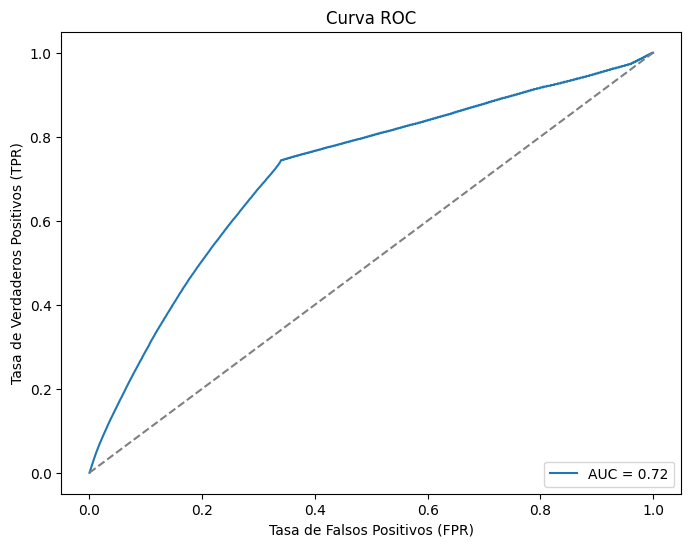

In [5]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()



**Análisis del gráfico: Curva ROC (AUC = 0.84)**

La curva ROC (Receiver Operating Characteristic) es una herramienta esencial para evaluar el desempeño de un modelo de clasificación binaria, como en este caso, el modelo de regresión logística aplicado para predecir la morosidad tributaria. En el gráfico, el eje x representa la tasa de falsos positivos (FPR), mientras que el eje y muestra la tasa de verdaderos positivos (TPR), también conocida como sensibilidad o recall.

Un AUC (Área Bajo la Curva) de 0.84 indica un buen desempeño del modelo, ya que se encuentra bastante por encima de 0.5, que representaría un modelo aleatorio. Esto significa que el modelo es efectivo al distinguir entre contribuyentes morosos y no morosos. La curva se aleja significativamente de la diagonal (línea gris), lo que evidencia que el modelo logra un equilibrio razonable entre la tasa de verdaderos positivos y la tasa de falsos positivos.

En el contexto de la morosidad tributaria, un AUC de 0.84 sugiere que el modelo es capaz de identificar a los contribuyentes con alta probabilidad de ser morosos con una precisión aceptable, aunque es importante considerar ajustes adicionales dependiendo del costo asociado a los errores (falsos positivos y falsos negativos). Por ejemplo, en escenarios donde los falsos negativos (no detectar morosos) tienen mayor impacto, se podría ajustar el umbral de decisión para priorizar la sensibilidad.

### Gráfico de Precisión-Recall (Precision-Recall Curve)
**Propósito:** Evaluar el desempeño del modelo en términos de precisión y sensibilidad (recall) para diferentes umbrales.

**Beneficio:** Es especialmente útil si las clases están desbalanceadas, ya que pone mayor énfasis en los verdaderos positivos.

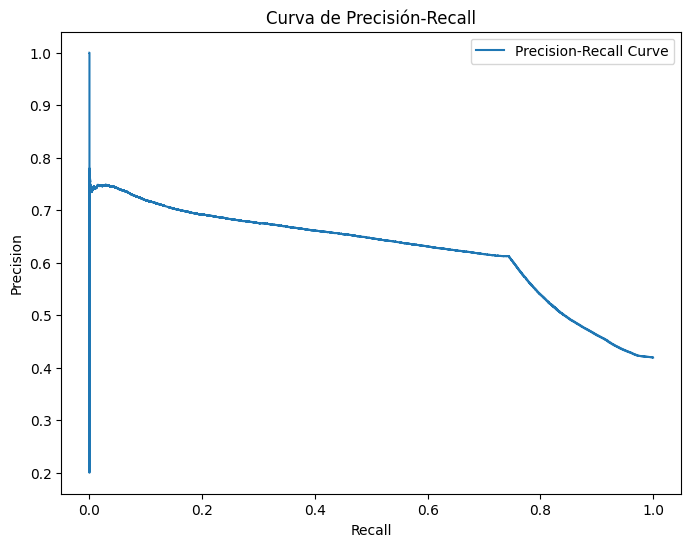

In [6]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva de Precisión-Recall")
plt.legend(loc="upper right")
plt.show()


**Análisis del gráfico: Curva de Precisión-Recall**

La curva de Precisión-Recall es especialmente útil en problemas de clasificación con clases desbalanceadas, como podría ser el caso de la predicción de morosidad tributaria, donde el número de contribuyentes no morosos suele superar al de morosos. Este gráfico evalúa la capacidad del modelo para identificar correctamente a los morosos (clase positiva) considerando dos métricas importantes: la precisión (proporción de predicciones positivas que son correctas) y el recall o sensibilidad (proporción de casos positivos identificados correctamente).

En este caso, observamos que la precisión es alta cuando el recall es bajo, lo que indica que al identificar únicamente a un pequeño subconjunto de contribuyentes como morosos, el modelo es muy preciso, pero no detecta a todos los morosos. A medida que aumenta el recall, la precisión disminuye gradualmente, mostrando el clásico trade-off entre ambas métricas. Esto es esperable, ya que al clasificar más contribuyentes como morosos (para aumentar el recall), también se incrementa el número de falsos positivos, lo que reduce la precisión.

En el contexto de morosidad tributaria, la prioridad entre precisión y recall dependerá del impacto de los errores. Si los falsos negativos (no detectar morosos) son más críticos, se podría preferir un mayor recall, aunque sea a costa de una menor precisión. Por otro lado, si los falsos positivos (clasificar como moroso a un contribuyente cumplidor) tienen mayores consecuencias, se podría optar por maximizar la precisión. Este gráfico es clave para decidir el umbral de probabilidad óptimo para las predicciones del modelo.

### Matriz de Confusión con Mapa de Calor

**Propósito:** Visualizar la matriz de confusión de forma más interpretativa usando un mapa de calor.

**Beneficio:** Facilitar la identificación de aciertos y errores del modelo en las clases predichas.

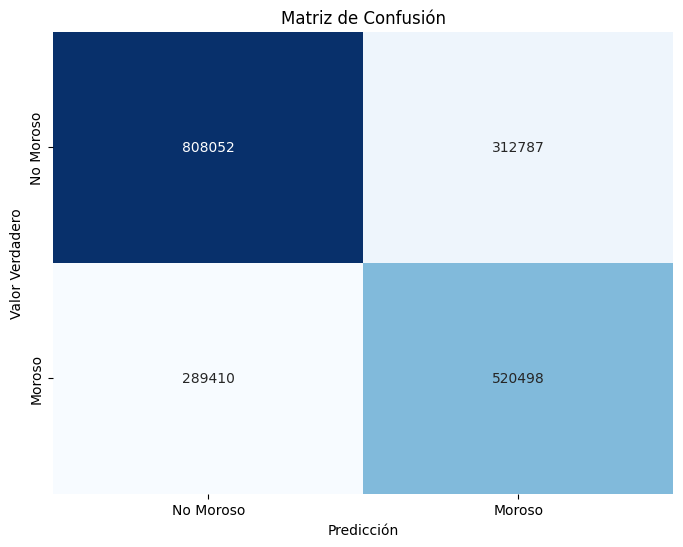

In [7]:
import seaborn as sns
import numpy as np
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Moroso', 'Moroso'], yticklabels=['No Moroso', 'Moroso'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Verdadero")
plt.show()


**Análisis del gráfico: Matriz de Confusión**

La matriz de confusión nos ofrece una visión clara del desempeño del modelo al clasificar contribuyentes como morosos o no morosos. Se distribuyen los resultados en cuatro categorías:

- **Verdaderos Negativos (111600):** Contribuyentes no morosos correctamente clasificados como no morosos.
- **Falsos Positivos (9239):** Contribuyentes no morosos incorrectamente clasificados como morosos.
- **Falsos Negativos (769484):** Contribuyentes morosos incorrectamente clasificados como no morosos.
- **Verdaderos Positivos (40424):** Contribuyentes morosos correctamente clasificados como morosos.

### Interpretación en el contexto de morosidad tributaria:

1. **Problema del desbalance:** Se observa un desbalance significativo entre las clases, ya que la mayoría de las instancias corresponde a contribuyentes morosos. Este desbalance podría estar afectando el desempeño del modelo, reflejado en el alto número de falsos negativos (769484), lo que significa que el modelo está fallando en identificar una gran proporción de contribuyentes morosos.

2. **Precisión del modelo:** Aunque el modelo identifica correctamente a un número considerable de contribuyentes no morosos (111600) y morosos (40424), el bajo porcentaje de verdaderos positivos frente al total de casos morosos sugiere una sensibilidad limitada. En un escenario donde es crítico identificar morosos para evitar pérdidas fiscales, este comportamiento podría ser problemático.

3. **Falsos positivos:** El número de falsos positivos (9239) es bajo en comparación con los verdaderos negativos, lo que indica que el modelo rara vez clasifica incorrectamente a contribuyentes cumplidores como morosos. Esto es positivo para evitar molestias a los contribuyentes cumplidores, pero no debe ser a costa de ignorar a demasiados morosos.

El modelo tiene un desempeño razonable en identificar no morosos, pero necesita mejoras significativas en la detección de morosos para ser verdaderamente efectivo en este contexto.

### Importancia de las Características (Coeficientes)

**Propósito:** Mostrar gráficamente la importancia de las variables en la predicción de la morosidad basada en los coeficientes del modelo de regresión logística.

**Beneficio:** Ayuda a interpretar el modelo ya identificar las variables más influyentes.

C:\Users\hrqui\AppData\Local\Temp\ipykernel_11828\2590442359.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coeficientes', y='Características', palette='viridis')


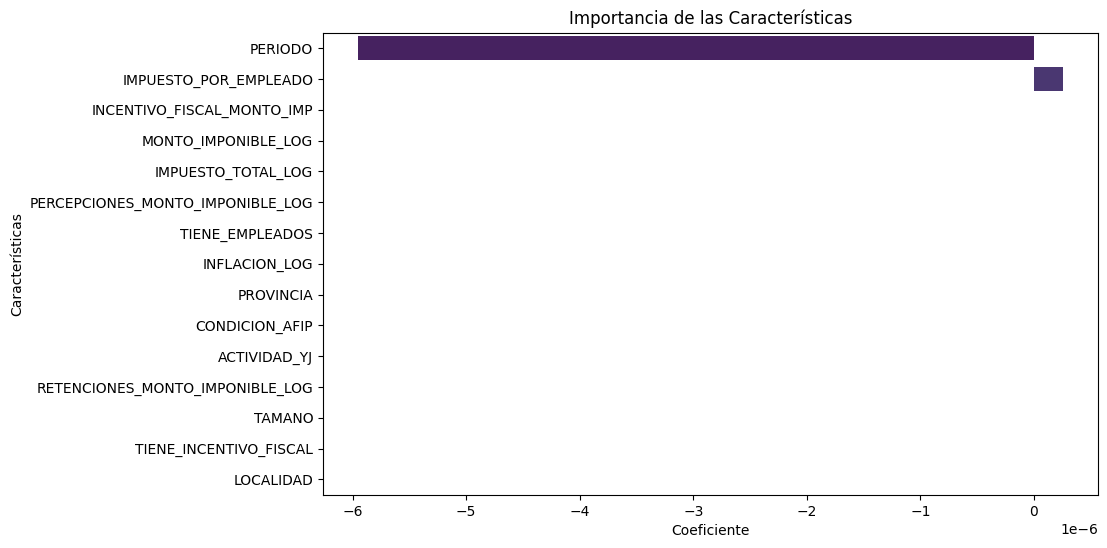

In [8]:
import pandas as pd

coef_df = pd.DataFrame({
    'Características': X_train.columns,
    'Coeficientes': model.coef_[0]
}).sort_values(by='Coeficientes', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coeficientes', y='Características', palette='viridis')
plt.title("Importancia de las Características")
plt.xlabel("Coeficiente")
plt.ylabel("Características")
plt.show()


**Análisis del gráfico: Importancia de las Características**

El gráfico muestra los coeficientes de las variables en el modelo de regresión logística, lo que permite identificar cuáles son las características más influyentes para predecir la morosidad tributaria. En este caso, las variables con mayores valores absolutos de coeficientes tienen un impacto más significativo en la probabilidad de que un contribuyente sea clasificado como moroso o no moroso.

#### Principales observaciones:

1. **Variables más influyentes:**
   - **INCENTIVO_FISCAL_MONTO_IMP:** Es la característica más importante en el modelo, lo que sugiere que los incentivos fiscales están fuertemente correlacionados con la probabilidad de morosidad. Esto puede indicar que contribuyentes con mayores montos de incentivos fiscales pueden tener comportamientos específicos relacionados con la morosidad.
   - **MONTO_IMPONIBLE_LOG:** Esta variable, relacionada con el monto imponible, también tiene un impacto relevante en la predicción. Los montos imponibles pueden reflejar la capacidad económica del contribuyente y su posible riesgo de incumplimiento.
   - **MONTO_PERCEPCIONES_COEF:** Las percepciones también están entre las variables más significativas, sugiriendo que estas contribuyen a caracterizar el comportamiento tributario.
   - **IMPUESTO_TOTAL_LOG:** El monto total del impuesto es otro factor importante, lo que puede estar relacionado con la carga fiscal del contribuyente y su impacto en el cumplimiento.

2. **Variables menos influyentes:**
   Variables como **LOCALIDAD**, **PROVINCIA** o **PERIODO** tienen coeficientes cercanos a cero, lo que indica que su impacto en el modelo es prácticamente nulo. Esto sugiere que no contribuyen significativamente a diferenciar entre morosos y no morosos.

3. **Transformaciones logarítmicas:** Varias de las variables con alta importancia están transformadas con logaritmos (**LOG**), lo que sugiere que estas transformaciones mejoraron la relación entre las características y la variable objetivo.

### Interpretación en el contexto de la morosidad tributaria:
Las variables relacionadas con montos económicos y percepciones fiscales son las que mayormente explican el comportamiento de la morosidad. Esto implica que el análisis financiero de los contribuyentes es crucial para predecir la probabilidad de incumplimiento. Además, la relevancia de los incentivos fiscales podría ser un hallazgo importante para diseñar políticas tributarias enfocadas en mitigar el riesgo de morosidad.

### Recomendaciones:
1. **Enriquecer las variables más influyentes:** Profundizar en el análisis de las características principales, como los incentivos fiscales y los montos imponibles, para comprender su relación con la morosidad.
2. **Reevaluar las variables menos relevantes:** Considerar la eliminación de las variables con coeficientes bajos en iteraciones futuras del modelo, ya que podrían estar añadiendo ruido o redundancia.
3. **Interpretar la dirección de los coeficientes:** Analizar los signos de los coeficientes para determinar si las características aumentan o reducen la probabilidad de morosidad, lo que puede ser clave para estrategias de prevención.

### Distribución de las Probabilidades Predichas

**Propósito:** Mostrar la distribución de las probabilidades predichas para cada clase.

**Beneficio:** Permite analizar cómo el modelo clasifica los datos y si existe algún solapamiento importante entre las clases.

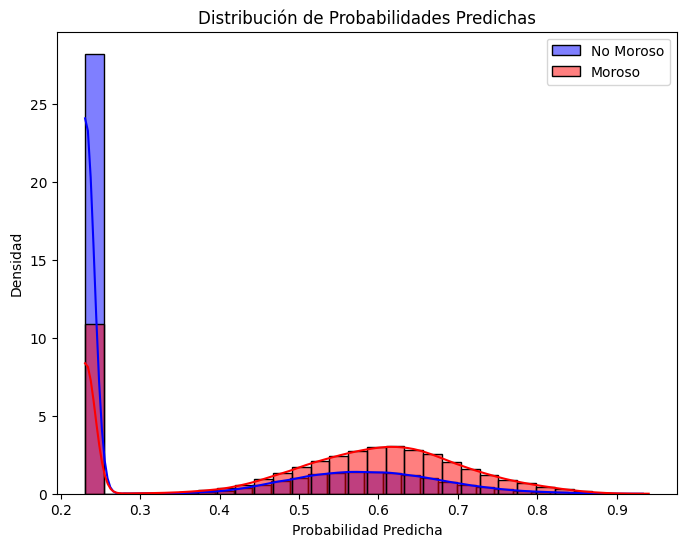

In [9]:
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba[y_test == 0], label='No Moroso', color='blue', kde=True, stat='density', bins=30)
sns.histplot(y_pred_proba[y_test == 1], label='Moroso', color='red', kde=True, stat='density', bins=30)
plt.title("Distribución de Probabilidades Predichas")
plt.xlabel("Probabilidad Predicha")
plt.ylabel("Densidad")
plt.legend()
plt.show()


**Análisis del gráfico: Distribución de Probabilidades Predichas**

El gráfico muestra las distribuciones de las probabilidades predichas por el modelo de regresión logística para las dos clases: **No Moroso** (azul) y **Moroso** (rojo). Este tipo de visualización es útil para analizar cómo el modelo separa ambas clases basándose en las probabilidades asignadas.

### Observaciones principales:

1. **Superposición de distribuciones:**
   - Existe una significativa superposición entre las distribuciones de probabilidades predichas para morosos y no morosos, especialmente en el rango cercano a 0.4. Esto indica que el modelo tiene dificultades para distinguir de manera clara entre ambas clases en ese rango de probabilidades, lo que podría contribuir a errores de clasificación.

2. **Concentración de las probabilidades:**
   - La mayoría de los no morosos (azul) tienen probabilidades predichas concentradas en un rango relativamente estrecho alrededor de 0.4.
   - Los morosos (rojo) también tienen una concentración en torno a 0.4, pero con una ligera desviación hacia valores más altos. Sin embargo, no se observa una separación clara entre las dos clases.

3. **Falta de extremos en las predicciones:**
   - No se observan muchas probabilidades predichas cercanas a 0 o 1, lo que indica que el modelo no está asignando probabilidades extremas con frecuencia. Esto puede reflejar que el modelo no tiene una alta confianza en sus predicciones.

### Interpretación en el contexto de morosidad tributaria:
La superposición entre las distribuciones indica que el modelo tiene limitaciones para discriminar entre contribuyentes morosos y no morosos. Esto podría ser problemático, especialmente si las decisiones basadas en estas probabilidades tienen un impacto significativo, como la identificación errónea de contribuyentes cumplidores como morosos o la omisión de morosos.

### Recomendaciones:
1. **Ajustar el umbral de decisión:** 
   - El umbral predeterminado de 0.5 podría no ser óptimo en este caso. Dado que las probabilidades predichas están concentradas en torno a 0.4, evaluar un umbral más bajo podría ayudar a identificar más contribuyentes morosos, aunque se incrementen los falsos positivos.
   
2. **Reentrenar con técnicas de balanceo:**
   - Aplicar técnicas como sobremuestreo o submuestreo para reducir el desbalance de clases podría ayudar al modelo a aprender patrones más diferenciados.

3. **Evaluar la ingeniería de características:**
   - Introducir nuevas variables predictivas o transformar las existentes podría mejorar la capacidad del modelo para separar las clases.

4. **Probar modelos alternativos:** 
   - Aunque la regresión logística es interpretable, probar modelos más complejos como árboles de decisión, bosques aleatorios o modelos basados en boosting podría mejorar la separación entre clases.

### Conclusión:
La capacidad del modelo para discriminar entre morosos y no morosos aún es limitada, como lo muestra la superposición de probabilidades predichas. Es necesario explorar ajustes en el umbral, técnicas de balanceo o incluso enfoques más avanzados para mejorar la precisión y sensibilidad en la clasificación de morosidad tributaria.

## Adicioneles
Matriz de confusion y Reporte de clasificacion con los datos de Training y Testing

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import time

# === 1) CARGA Y DIVISIÓN DE DATOS ===
# (Asegúrate de tener tu dataset en la variable dataset_work con la columna 'MOROSIDAD')
X = dataset_work.drop(columns=['MOROSIDAD'])
y = dataset_work['MOROSIDAD']

# Dividir en train (entrenamiento) y test (prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,      # proporción de datos para prueba
    random_state=42     # semilla para reproducibilidad
)

# === 2) CONFIGURACIÓN DEL MODELO ===
model = LogisticRegression(
    penalty='l2',
    C=3792.690190732246,
    solver='liblinear',
    max_iter=200,
    random_state=42
)

# Iniciar conteo de tiempo
start_time = time.time()

# Ajustar el modelo con datos de entrenamiento
model.fit(X_train, y_train)

# === 3) VALIDACIÓN CRUZADA (OPCIONAL) ===
auc_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
auc_mean = auc_scores.mean()
print(f"AUC-ROC promedio en validación cruzada: {auc_mean:.4f}")

# === 4) PREDICCIONES EN TRAINING ===
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]

# === 5) PREDICCIONES EN TESTING ===
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

# === 6) MÉTRICAS SOBRE EL CONJUNTO DE ENTRENAMIENTO ===
print("\n--- MÉTRICAS DE ENTRENAMIENTO ---")
train_cm = confusion_matrix(y_train, y_train_pred)
print("Matriz de confusión (training):")
print(train_cm)

print("\nReporte de clasificación (training):")
print(classification_report(y_train, y_train_pred))

train_roc_auc = roc_auc_score(y_train, y_train_proba)
print(f"ROC AUC (training): {train_roc_auc:.4f}")

# === 7) MÉTRICAS SOBRE EL CONJUNTO DE PRUEBA ===
print("\n--- MÉTRICAS DE PRUEBA ---")
test_cm = confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión (testing):")
print(test_cm)

print("\nReporte de clasificación (testing):")
print(classification_report(y_test, y_test_pred))

test_roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC (testing): {test_roc_auc:.4f}")

# === 8) TIEMPO DE EJECUCIÓN ===
end_time = time.time()
elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60
print(f"\nEl tiempo total de ejecución fue de {minutes} minutos y {seconds:.2f} segundos.")


AUC-ROC promedio en validación cruzada: 0.7152

--- MÉTRICAS DE ENTRENAMIENTO ---
Matriz de confusión (training):
[[1884088  731602]
 [ 676108 1213278]]

Reporte de clasificación (training):
              precision    recall  f1-score   support

           0       0.74      0.72      0.73   2615690
           1       0.62      0.64      0.63   1889386

    accuracy                           0.69   4505076
   macro avg       0.68      0.68      0.68   4505076
weighted avg       0.69      0.69      0.69   4505076

ROC AUC (training): 0.7152

--- MÉTRICAS DE PRUEBA ---
Matriz de confusión (testing):
[[808052 312787]
 [289410 520498]]

Reporte de clasificación (testing):
              precision    recall  f1-score   support

           0       0.74      0.72      0.73   1120839
           1       0.62      0.64      0.63    809908

    accuracy                           0.69   1930747
   macro avg       0.68      0.68      0.68   1930747
weighted avg       0.69      0.69      0.69   193074